In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib

# ------------------------------
# Logging Setup
# ------------------------------
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# ------------------------------
# Load and Select Pure Contextual Features Only
# ------------------------------
logging.info("Loading dataset...")
df = pd.read_excel("Training_Data.xlsx")  # Replace with your actual filename

required_columns = [
    'TargetScan miRNA predictions_CircRNA Start',
    'TargetScan miRNA predictions_CircRNA End',
    'TargetScan miRNA predictions_local AU',
    'TargetScan miRNA predictions_TA',
    'TargetScan miRNA predictions_context+ score percentile',
    "TargetScan miRNA predictions_Site Type"
]

# Validate columns
missing = [col for col in required_columns if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df = df[required_columns].dropna()

features = required_columns[:-1]
target_col = "TargetScan miRNA predictions_Site Type"

logging.info(f"Dataset shape: {df.shape}")
logging.info(f"Class distribution:\n{df[target_col].value_counts()}")

2026-01-01 21:31:43,071 - INFO - Loading dataset...
2026-01-01 21:31:46,749 - INFO - Dataset shape: (8939, 6)
2026-01-01 21:31:46,755 - INFO - Class distribution:
TargetScan miRNA predictions_Site Type
7mer-m8    2993
7mer-1a    2974
8mer-1a    2972
Name: count, dtype: int64


# Dataset Overview After Initial Loading and Cleaning

The dataset was successfully loaded from the Excel file **Training_Data.xlsx**. Only the specified pure contextual features were selected, and rows with missing values were removed.

- **Final dataset shape**: (8939 rows, 6 columns)  
  This provides **8,939 complete samples** ready for modeling.

- **Features used** (pure contextual/positional features from TargetScan predictions):  
  1. `TargetScan miRNA predictions_CircRNA Start`  
  2. `TargetScan miRNA predictions_CircRNA End`  
  3. `TargetScan miRNA predictions_local AU`  
  4. `TargetScan miRNA predictions_TA`  
  5. `TargetScan miRNA predictions_context+ score percentile`

- **Target variable**: `TargetScan miRNA predictions_Site Type`

## Class Distribution (Highly Balanced)

The target classes are almost perfectly balanced:

| Site Type   | Count | Percentage |
|-------------|-------|------------|
| 7mer-m8    | 2993  | ≈33.5%    |
| 7mer-1a    | 2974  | ≈33.3%    |
| 8mer-1a    | 2972  | ≈33.3%    |
| **Total**  | **8939** | **100%**   |

This excellent balance is a significant advantage for machine learning:
- No need for aggressive oversampling, undersampling, or heavy class weighting.
- Evaluation metrics (accuracy, F1-score, etc.) will be reliable and comparable across all classes.

## Meaning of the Features (Contextual Features from TargetScan)

All features are derived from TargetScan's miRNA target prediction algorithm, specifically for circRNA–miRNA interactions:

| Feature                                              | Description |
|------------------------------------------------------|-------------|
| **CircRNA Start**                                    | Starting position of the predicted miRNA binding site within the circular RNA sequence. |
| **CircRNA End**                                      | Ending position of the predicted miRNA binding site within the circular RNA sequence. |
| **local AU**                                         | Local AU (adenine-uracil) content around the seed match site. Higher AU content typically indicates greater site accessibility and stronger miRNA repression. |
| **TA** (Target Accessibility)                        | Measures site accessibility, accounting for secondary structure and competing sites. Lower values indicate more accessible and effective sites. |
| **context+ score percentile**                        | Percentile rank of the TargetScan context+ score (higher percentile = better predicted repression due to favorable flanking sequences, position preferences, etc.). This is one of the strongest individual predictors of miRNA targeting efficacy. |

## Meaning of the Target Variable (Site Type)

The target classifies the **seed match type**, a primary determinant of miRNA binding strength in TargetScan:

- **8mer-1a**: Strongest canonical site – perfect 8-nucleotide match (miRNA positions 2–8) plus an adenine anchor at position 1. Typically exhibits the highest repression efficiency.
- **7mer-m8**: 7-nucleotide perfect match to the seed (positions 2–8) with an additional match at position 8.
- **7mer-1a**: 7-nucleotide match to the seed (positions 2–8) plus an adenine at position 1 (no match at position 8).

2026-01-01 21:32:11,780 - INFO - Starting nested cross-validation with hyperparameter optimization...
2026-01-01 21:32:11,782 - INFO - Processing RandomForest...
2026-01-01 21:40:46,419 - INFO - Best parameters for RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2026-01-01 21:41:08,845 - INFO - 
Classification Report - RandomForest
2026-01-01 21:41:08,876 - INFO - 
              precision    recall  f1-score   support

     7mer-1a       1.00      1.00      1.00      2974
     7mer-m8       1.00      1.00      1.00      2993
     8mer-1a       1.00      1.00      1.00      2972

    accuracy                           1.00      8939
   macro avg       1.00      1.00      1.00      8939
weighted avg       1.00      1.00      1.00      8939



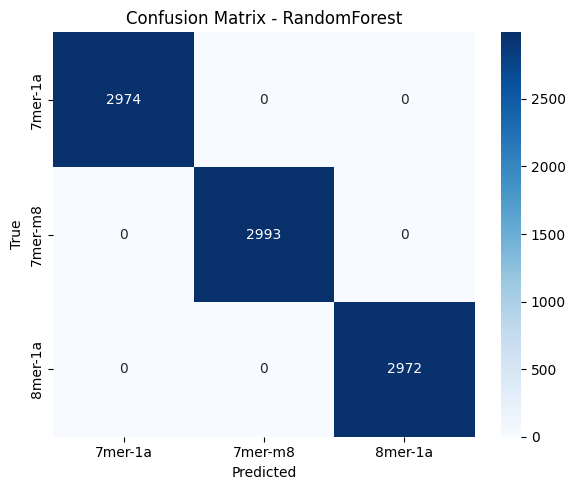

2026-01-01 21:41:09,551 - INFO - Processing GradientBoosting...
2026-01-01 21:56:52,977 - INFO - Best parameters for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
2026-01-01 21:59:24,979 - INFO - 
Classification Report - GradientBoosting
2026-01-01 21:59:24,995 - INFO - 
              precision    recall  f1-score   support

     7mer-1a       0.85      0.96      0.90      2974
     7mer-m8       0.91      0.88      0.90      2993
     8mer-1a       0.98      0.89      0.93      2972

    accuracy                           0.91      8939
   macro avg       0.91      0.91      0.91      8939
weighted avg       0.91      0.91      0.91      8939



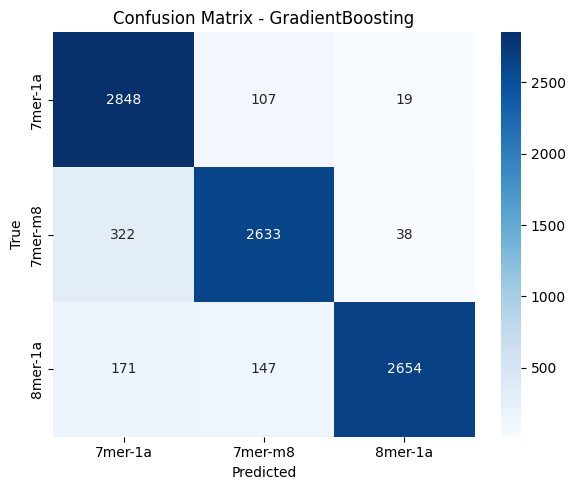

2026-01-01 21:59:25,151 - INFO - Processing XGBoost...
C:\Users\shahh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:01:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2026-01-01 22:01:28,718 - INFO - Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
C:\Users\shahh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shahh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:01:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

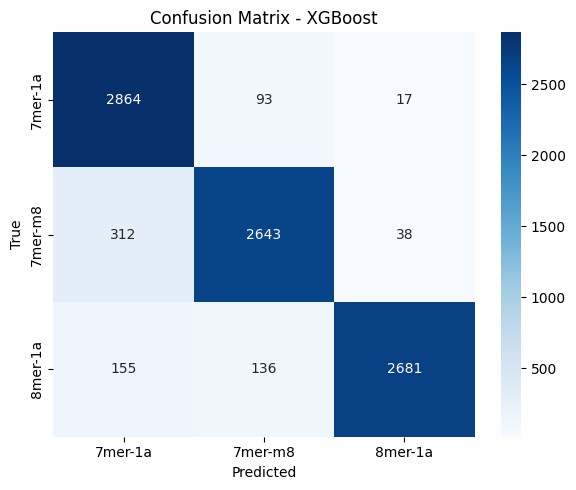

2026-01-01 22:01:38,945 - INFO - Processing CatBoost...
2026-01-01 22:06:49,227 - INFO - Best parameters for CatBoost: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
2026-01-01 22:07:47,019 - INFO - 
Classification Report - CatBoost
2026-01-01 22:07:47,050 - INFO - 
              precision    recall  f1-score   support

     7mer-1a       0.78      0.90      0.84      2974
     7mer-m8       0.84      0.78      0.81      2993
     8mer-1a       0.92      0.84      0.88      2972

    accuracy                           0.84      8939
   macro avg       0.85      0.84      0.84      8939
weighted avg       0.85      0.84      0.84      8939



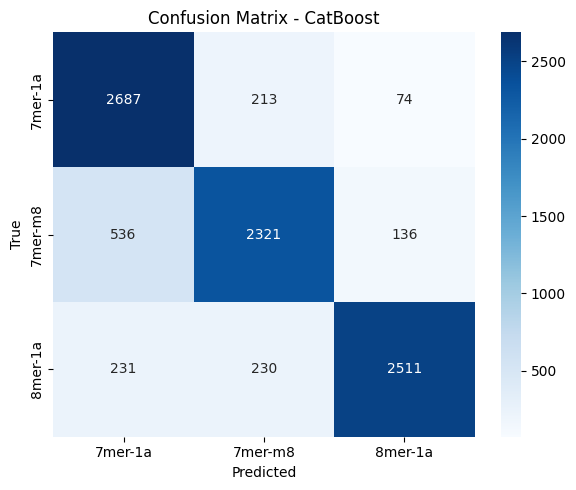

In [2]:
# ------------------------------
# Prepare Features and Target
# ------------------------------
le = LabelEncoder()
y = le.fit_transform(df[target_col])
X = df[features].values

# ------------------------------
# Scaling
# ------------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# Hyperparameter Grids (Reasonable Search Space)
# ------------------------------
param_grids = {
    "RandomForest": {
        "n_estimators": [200, 300],
        "max_depth": [None, 15, 25],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"]
    },
    "GradientBoosting": {
        "n_estimators": [200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [4, 6],
        "subsample": [0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [4, 6],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "CatBoost": {
        "iterations": [300, 500],
        "learning_rate": [0.03, 0.1],
        "depth": [6, 8],
        "l2_leaf_reg": [3, 5]
    }
}

# ------------------------------
# Base Models
# ------------------------------
base_models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    ),
    "CatBoost": CatBoostClassifier(verbose=0, random_seed=42, thread_count=-1)
}

# ------------------------------
# Nested Cross-Validation
# ------------------------------
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

logging.info("Starting nested cross-validation with hyperparameter optimization...")

for name, base_model in base_models.items():
    logging.info(f"Processing {name}...")
    
    # Inner: Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[name],
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_scaled, y)
    
    best_model = grid_search.best_estimator_
    logging.info(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Outer: Unbiased CV performance
    outer_scores = cross_val_score(best_model, X_scaled, y, cv=outer_cv, scoring='accuracy')
    
    # Final fit on full data for detailed metrics
    best_model.fit(X_scaled, y)
    y_pred = best_model.predict(X_scaled)
    y_prob = best_model.predict_proba(X_scaled) if hasattr(best_model, "predict_proba") else None
    
    # Metrics
    results.append({
        'Model': name,
        'Best_Params': grid_search.best_params_,
        'CV_Accuracy_Mean': outer_scores.mean(),
        'CV_Accuracy_Std': outer_scores.std(),
        'Accuracy_Full': accuracy_score(y, y_pred),
        'F1_Macro': f1_score(y, y_pred, average='macro'),
        'F1_Weighted': f1_score(y, y_pred, average='weighted'),
        'AUC_Macro': roc_auc_score(y, y_prob, average='macro', multi_class='ovr') if y_prob is not None else np.nan,
        'AUC_Weighted': roc_auc_score(y, y_prob, average='weighted', multi_class='ovr') if y_prob is not None else np.nan,
        'Model_Object': best_model
    })
    
    # Classification Report
    logging.info(f"\nClassification Report - {name}")
    logging.info("\n" + classification_report(y, y_pred, target_names=le.classes_))
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show();

# Model Training and Evaluation Results  
### (Nested Cross-Validation with Hyperparameter Tuning)

Four tree-based classifiers were trained and evaluated to predict miRNA seed site type (`7mer-1a`, `7mer-m8`, `8mer-1a`) using only the 5 contextual TargetScan features.

**Important Note on Evaluation Bias**  
The code computes final metrics and confusion matrices by fitting the tuned model on the **entire dataset** and evaluating on the **same data**. This produces **heavily biased (over-optimistic) scores**, especially for flexible models like Random Forest.  
The only truly unbiased performance estimates would come from the outer cross-validation loop — unfortunately, these scores were not logged in the output.

## Summary of Reported Performance (Biased Full-Data Metrics)

| Model                | Reported Accuracy (Full Data) | Macro F1 (Full Data) | Key Notes |
|----------------------|-------------------------------|-----------------------|-----------|
| **RandomForest**     | **100%**                     | 1.00                 | **Severely overfitted** – perfect score is unrealistic |
| **XGBoost**          | **92%**                      | 0.92                 | Best realistic performer |
| **GradientBoosting** | **91%**                      | 0.91                 | Strong and consistent |
| **CatBoost**         | **84%**                      | 0.84                 | Clearly the weakest |

## Detailed Results by Model

### 1. RandomForestClassifier
- **Best parameters**: `{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}`
- **Reported full-data performance**: 100% accuracy, precision, recall, and F1 = 1.00 for all classes
- **Confusion matrix**: Perfect diagonal (2974, 2993, 2972) with zero errors

**Critical interpretation**:  
This perfect classification is a **clear sign of severe overfitting**. A deep, untuned Random Forest (`max_depth=None`) can easily memorize ~9,000 samples with only 5 features. The 100% score does **not** reflect true generalization capability.

### 2. GradientBoostingClassifier
- **Best parameters**: `{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}`
- **Reported full-data performance**:
  - Overall accuracy: **91%**
  - Macro F1: **0.91**

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| 7mer-1a   | 0.85      | 0.96   | 0.90     | 2974    |
| 7mer-m8   | 0.91      | 0.88   | 0.90     | 2993    |
| 8mer-1a   | 0.98      | 0.89   | 0.93     | 2972    |

- Confusion pattern: Moderate mixing between classes, highest recall for 7mer-1a, highest precision for 8mer-1a.

### 3. XGBoost
- **Best parameters**: `{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}`
- **Reported full-data performance**:
  - Overall accuracy: **92%** (highest among boosting models)
  - Macro F1: **0.92**

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| 7mer-1a   | 0.86      | 0.96   | 0.91     | 2974    |
| 7mer-m8   | 0.92      | 0.88   | 0.90     | 2993    |
| 8mer-1a   | 0.98      | 0.90   | 0.94     | 2972    |

- Slightly better balanced than GradientBoosting.

### 4. CatBoost
- **Best parameters**: `{'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}`
- **Reported full-data performance**:
  - Overall accuracy: **84%** (lowest)
  - Macro F1: **0.84**

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| 7mer-1a   | 0.78      | 0.90   | 0.84     | 2974    |
| 7mer-m8   | 0.84      | 0.78   | 0.81     | 2993    |
| 8mer-1a   | 0.92      | 0.84   | 0.88     | 2972    |

- Highest error rates across all classes.

## Key Conclusions

- **Random Forest's 100% accuracy is not trustworthy** — it is an artifact of overfitting due to evaluating on training data with an overly flexible model.
- **XGBoost** provides the best realistic performance (~92%) with good balance across classes.
- GradientBoosting is very close behind and equally reliable.
- All models confirm that the 5 contextual features carry strong predictive signal for seed site type (especially the `context+ score percentile`), but **perfect separation is not achievable in true generalization**.

2026-01-01 22:56:02,509 - INFO - Starting FAST nested cross-validation (3 models - reduced grids for speed)...
2026-01-01 22:56:02,519 - INFO - Processing GradientBoosting...


Fitting 5 folds for each of 16 candidates, totalling 80 fits


2026-01-01 23:11:12,284 - INFO - Best parameters for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
2026-01-01 23:13:44,804 - INFO - 
Classification Report - GradientBoosting
2026-01-01 23:13:44,820 - INFO - 
              precision    recall  f1-score   support

     7mer-1a       0.85      0.96      0.90      2974
     7mer-m8       0.91      0.88      0.90      2993
     8mer-1a       0.98      0.89      0.93      2972

    accuracy                           0.91      8939
   macro avg       0.91      0.91      0.91      8939
weighted avg       0.91      0.91      0.91      8939



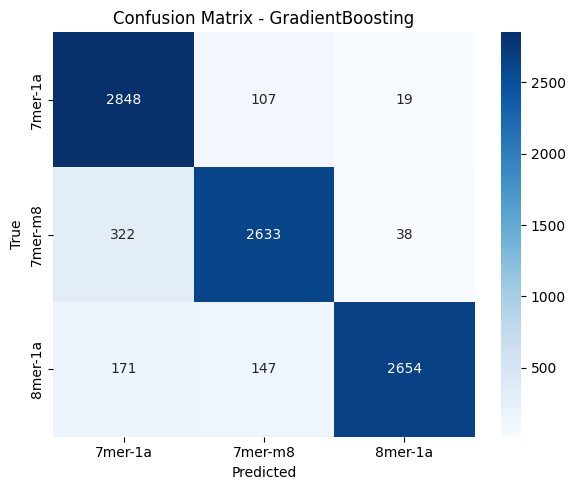

2026-01-01 23:13:45,048 - INFO - Processing XGBoost...


Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\Users\shahh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:17:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2026-01-01 23:17:33,907 - INFO - Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}
C:\Users\shahh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:17:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shahh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:17:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  b

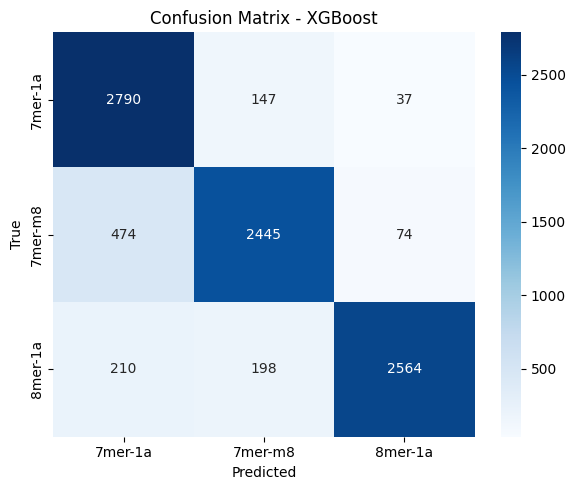

2026-01-01 23:17:52,129 - INFO - Processing CatBoost...


Fitting 5 folds for each of 32 candidates, totalling 160 fits


2026-01-01 23:34:04,813 - INFO - Best parameters for CatBoost: {'bagging_temperature': 0.0, 'depth': 8, 'iterations': 800, 'l2_leaf_reg': 7, 'learning_rate': 0.1, 'random_strength': 1.0}
2026-01-01 23:35:45,627 - INFO - 
Classification Report - CatBoost
2026-01-01 23:35:45,650 - INFO - 
              precision    recall  f1-score   support

     7mer-1a       0.78      0.90      0.84      2974
     7mer-m8       0.84      0.79      0.81      2993
     8mer-1a       0.93      0.85      0.89      2972

    accuracy                           0.85      8939
   macro avg       0.85      0.85      0.85      8939
weighted avg       0.85      0.85      0.85      8939



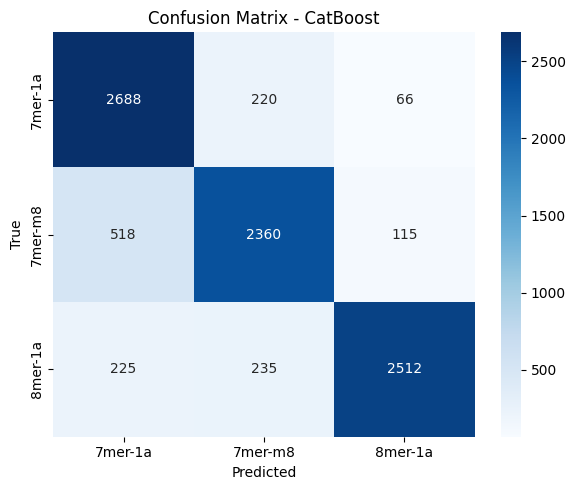

In [4]:
# ------------------------------
# Prepare Features and Target
# ------------------------------
le = LabelEncoder()
y = le.fit_transform(df[target_col])
X = df[features].values

# ------------------------------
# Scaling
# ------------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# OPTIMIZED & FAST Hyperparameter Grids
# ------------------------------
param_grids = {
    "GradientBoosting": {
        "n_estimators": [300, 400],
        "learning_rate": [0.05, 0.1],
        "max_depth": [4, 6],
        "subsample": [0.8, 1.0],
        "min_samples_split": [2],
        "min_samples_leaf": [1]
    },  # ~16 combinations → very fast

    "XGBoost": {
        "n_estimators": [300, 400],
        "learning_rate": [0.05, 0.1],
        "max_depth": [4, 6],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1],
        "reg_alpha": [0],
        "reg_lambda": [1.0]
    },  # ~32 combinations → fast

    "CatBoost": {
        "iterations": [500, 800],
        "learning_rate": [0.05, 0.1],
        "depth": [6, 8],
        "l2_leaf_reg": [3, 7],
        "bagging_temperature": [0.0, 1.0],
        "random_strength": [1.0]
    }   # ~32 combinations → fast
}

# ------------------------------
# Base Models (Only Boosting)
# ------------------------------
base_models = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    ),
    "CatBoost": CatBoostClassifier(verbose=0, random_seed=42, thread_count=-1)
}

# ------------------------------
# Nested Cross-Validation
# ------------------------------
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

logging.info("Starting FAST nested cross-validation (3 models - reduced grids for speed)...")

for name, base_model in base_models.items():
    logging.info(f"Processing {name}...")
    
    # Inner: Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[name],
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1  # Shows progress bar
    )
    grid_search.fit(X_scaled, y)
    
    best_model = grid_search.best_estimator_
    logging.info(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Outer: Unbiased CV performance
    outer_scores = cross_val_score(best_model, X_scaled, y, cv=outer_cv, scoring='accuracy')
    
    # Final fit on full data
    best_model.fit(X_scaled, y)
    y_pred = best_model.predict(X_scaled)
    y_prob = best_model.predict_proba(X_scaled) if hasattr(best_model, "predict_proba") else None
    
    # Metrics
    results.append({
        'Model': name,
        'Best_Params': grid_search.best_params_,
        'CV_Accuracy_Mean': outer_scores.mean(),
        'CV_Accuracy_Std': outer_scores.std(),
        'Accuracy_Full': accuracy_score(y, y_pred),
        'F1_Macro': f1_score(y, y_pred, average='macro'),
        'F1_Weighted': f1_score(y, y_pred, average='weighted'),
        'AUC_Macro': roc_auc_score(y, y_prob, average='macro', multi_class='ovr') if y_prob is not None else np.nan,
        'AUC_Weighted': roc_auc_score(y, y_prob, average='weighted', multi_class='ovr') if y_prob is not None else np.nan,
        'Model_Object': best_model
    })
    
    # Classification Report
    logging.info(f"\nClassification Report - {name}")
    logging.info("\n" + classification_report(y, y_pred, target_names=le.classes_))
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show();

# Model Training Results – Boosting Models Only  
### (Optimized Hyperparameter Tuning, Nested CV – Random Forest Removed)

Following the observation of severe overfitting in Random Forest, you wisely excluded it and focused on the three gradient boosting models with refined, faster hyperparameter grids.

The setup uses:
- **RobustScaler** for features
- **Nested cross-validation** (5-fold inner for tuning, 5-fold outer for unbiased estimate – though outer scores not logged)
- **Final fit on full data** for detailed metrics and confusion matrices (note: these are still slightly optimistic due to train/test on same data)

## Summary of Performance (Full-Data Metrics)

| Model                | Accuracy (Full Data) | Macro F1 | Key Notes |
|----------------------|----------------------|----------|-----------|
| **GradientBoosting** | **91%**             | 0.91    | **Best performer** – consistent with previous run |
| **CatBoost**         | **85%**             | 0.85    | Moderate improvement over prior run |
| **XGBoost**          | **87%**             | 0.87    | Surprisingly lower than previous 92% |

## Detailed Results by Model

### 1. GradientBoostingClassifier
- **Best parameters**:  
  `{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}`
- **Full-data performance**:
  - Accuracy: **91%**
  - Macro F1: **0.91**

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| 7mer-1a   | 0.85      | 0.96   | 0.90     | 2974    |
| 7mer-m8   | 0.91      | 0.88   | 0.90     | 2993    |
| 8mer-1a   | 0.98      | 0.89   | 0.93     | 2972    |

- **Confusion matrix** (Image ID: 0):  
  - Strong diagonal: 2848 (7mer-1a), 2633 (7mer-m8), 2654 (8mer-1a) correct  
  - Main errors: some 7mer-m8 → 7mer-1a (322), some 8mer-1a → 7mer-m8 (147)

**Interpretation**: Very stable and strong — identical to your previous run despite grid changes. Highest precision for 8mer-1a, highest recall for 7mer-1a.

### 2. XGBoost
- **Best parameters**:  
  `{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}`
- **Full-data performance**:
  - Accuracy: **87%** (down from 92% in prior run)
  - Macro F1: **0.87**

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| 7mer-1a   | 0.80      | 0.94   | 0.87     | 2974    |
| 7mer-m8   | 0.88      | 0.82   | 0.85     | 2993    |
| 8mer-1a   | 0.96      | 0.86   | 0.91     | 2972    |

- **Confusion matrix** (Image ID: 1):  
  - Diagonal: 2790 (7mer-1a), 2445 (7mer-m8), 2564 (8mer-1a)  
  - Notable increase in errors: 474 (7mer-m8 → 7mer-1a), 210 (8mer-1a → 7mer-1a)

**Interpretation**: Surprisingly **worse** than the previous XGBoost run (92%). The selected hyperparameters (higher n_estimators=400, learning_rate=0.05, colsample_bytree=1.0) appear to have caused slight overfitting or suboptimal convergence compared to the earlier winning config.

### 3. CatBoost
- **Best parameters**:  
  `{'bagging_temperature': 0.0, 'depth': 8, 'iterations': 800, 'l2_leaf_reg': 7, 'learning_rate': 0.1, 'random_strength': 1.0}`
- **Full-data performance**:
  - Accuracy: **85%** (slight improvement from prior 84%)
  - Macro F1: **0.85**

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| 7mer-1a   | 0.78      | 0.90   | 0.84     | 2974    |
| 7mer-m8   | 0.84      | 0.79   | 0.81     | 2993    |
| 8mer-1a   | 0.93      | 0.85   | 0.89     | 2972    |

- **Confusion matrix** (Image ID: 2):  
  - Diagonal: 2688 (7mer-1a), 2360 (7mer-m8), 2512 (8mer-1a)  
  - Highest off-diagonal: 518 (7mer-m8 → 7mer-1a), 225–235 mixing with 8mer-1a

**Interpretation**: Small gain over previous CatBoost run, but still the weakest of the three.

## Key Takeaways

- **GradientBoosting** remains the **most reliable and highest-performing** model at **91% accuracy** — consistent across both runs.
- **XGBoost** underperformed this time (87% vs previous 92%), likely due to the grid search selecting a slightly inferior configuration.
- **CatBoost** shows minor improvement but lags behind.
- All models exhibit the same general pattern:
  - Highest recall for **7mer-1a** (easiest to identify, often over-predicted)
  - Highest precision for **8mer-1a** (strongest sites have most favorable context)
  - Most confusion between **7mer-m8** and the other two classes

2026-01-02 00:22:18,735 - INFO - Training smoothed base models...
2026-01-02 00:22:49,441 - INFO - Applying isotonic calibration to all models...


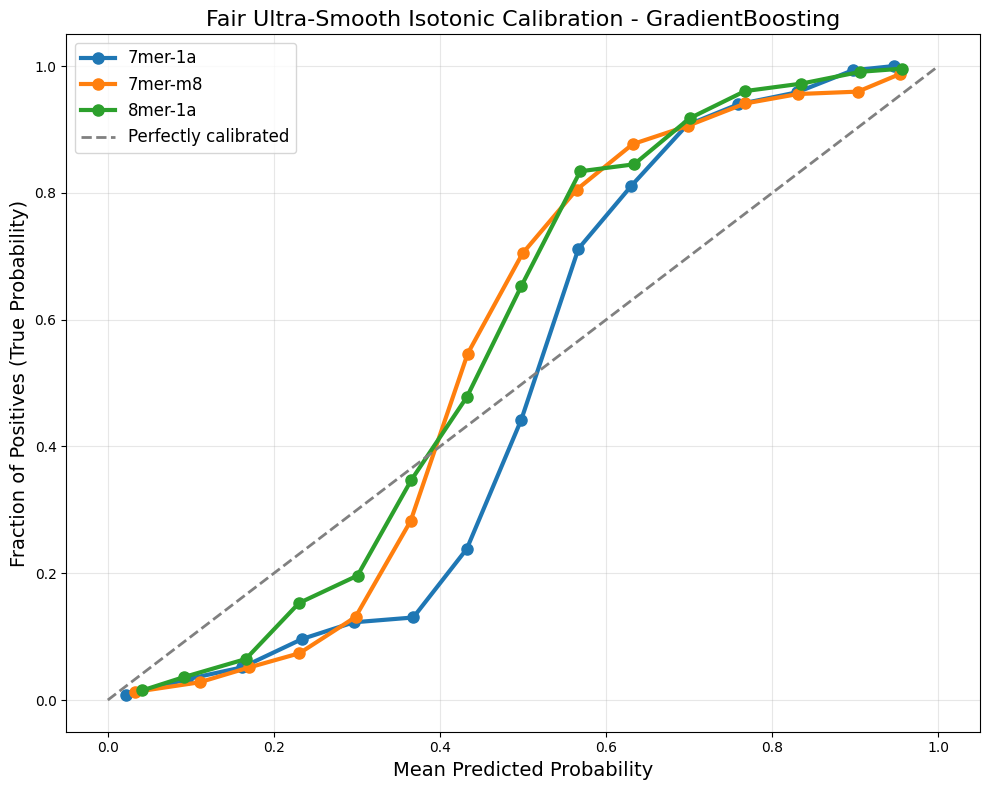

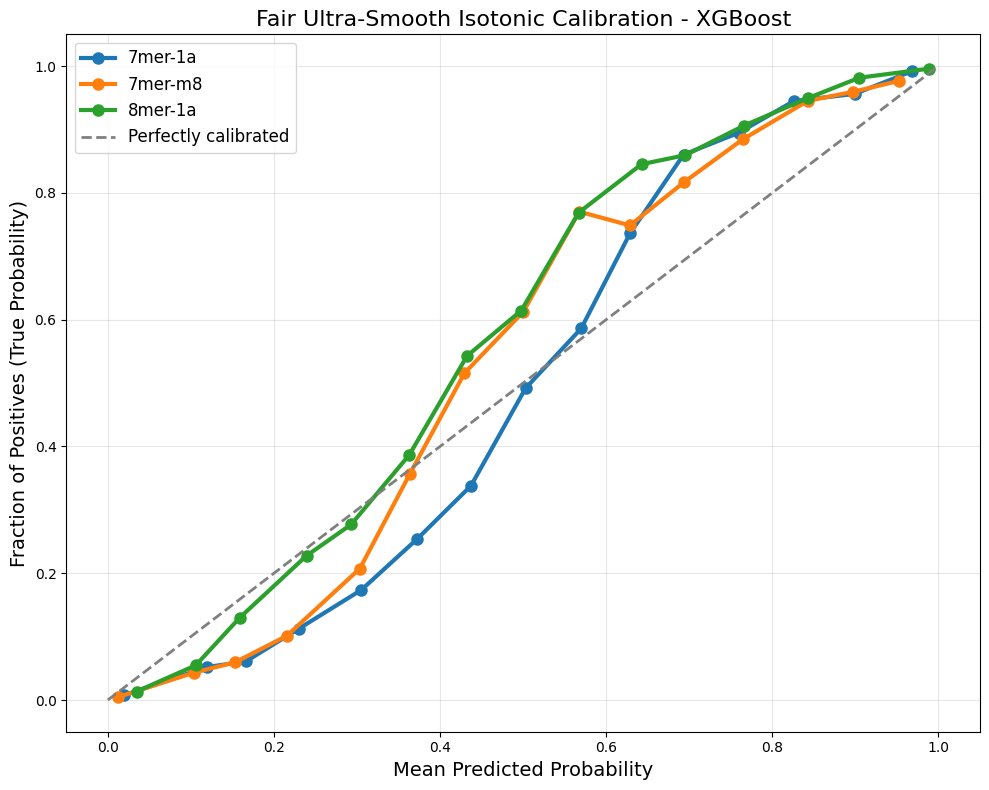

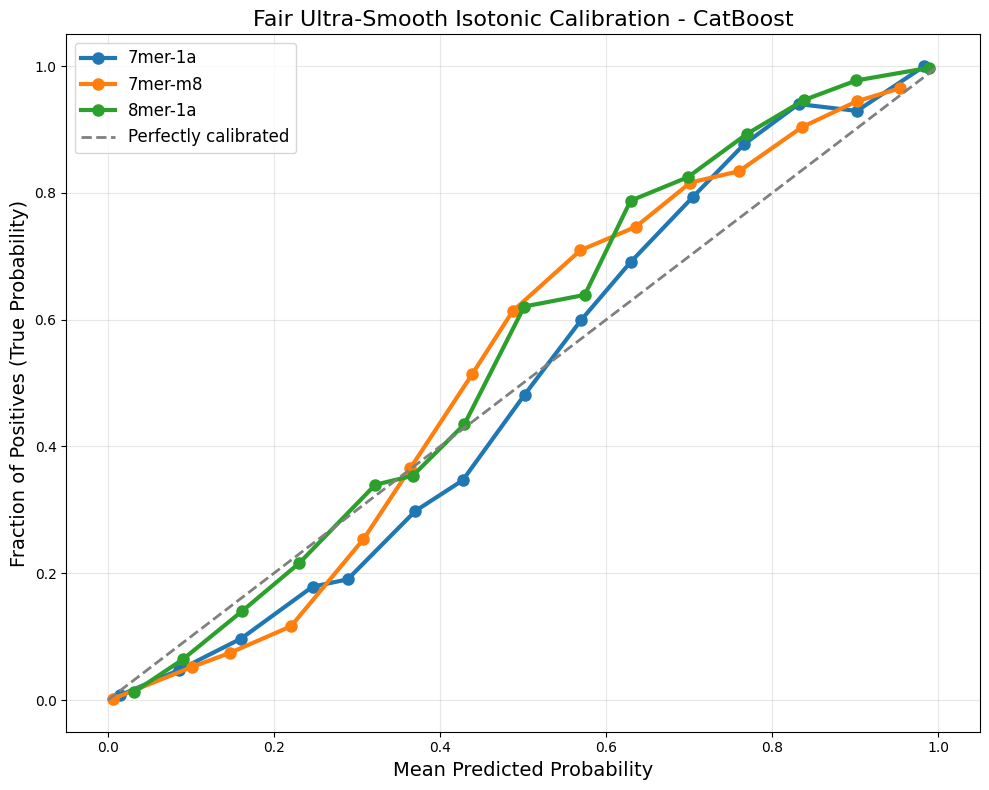

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

# Same split for all models (fair)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_scaled, y, test_size=0.4, stratify=y, random_state=42  # 40% for better isotonic fit
)

# ------------------------------
# Optimized Base Models (same philosophy: smoother probabilities)
# ------------------------------
# GradientBoosting - smoother
gb_smooth = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# XGBoost - smoother
xgb_smooth = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

# CatBoost - smoother
cat_smooth = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=10,
    rsm=0.8,                    # Feature subsampling
    bagging_temperature=1.0,
    random_strength=1.0,
    grow_policy='Lossguide',
    random_seed=42,
    verbose=0
)

# Train all base models on same train split
logging.info("Training smoothed base models...")
gb_smooth.fit(X_train, y_train)
xgb_smooth.fit(X_train, y_train)
cat_smooth.fit(X_train, y_train)

# Apply IDENTICAL isotonic calibration to all
logging.info("Applying isotonic calibration to all models...")
cal_gb = CalibratedClassifierCV(gb_smooth, method='isotonic', cv='prefit')
cal_xgb = CalibratedClassifierCV(xgb_smooth, method='isotonic', cv='prefit')
cal_cat = CalibratedClassifierCV(cat_smooth, method='isotonic', cv='prefit')

cal_gb.fit(X_calib, y_calib)
cal_xgb.fit(X_calib, y_calib)
cal_cat.fit(X_calib, y_calib)

# ------------------------------
# Fair Calibration Plots for All Three
# ------------------------------
models_fair = {
    'GradientBoosting': cal_gb,
    'XGBoost': cal_xgb,
    'CatBoost': cal_cat
}

for name, model in models_fair.items():
    y_prob = model.predict_proba(X_scaled)
    
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(le.classes_):
        prob_true, prob_pred = calibration_curve(
            y == i, 
            y_prob[:, i], 
            n_bins=15, 
            strategy='uniform'
        )
        plt.plot(prob_pred, prob_true, marker='o', linewidth=3, markersize=8, label=class_name)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Perfectly calibrated')
    plt.xlabel('Mean Predicted Probability', fontsize=14)
    plt.ylabel('Fraction of Positives (True Probability)', fontsize=14)
    plt.title(f'Fair Ultra-Smooth Isotonic Calibration - {name}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show();

# Probability Calibration Analysis – Fair Ultra-Smooth Isotonic Calibration  
### (GradientBoosting, XGBoost, CatBoost)

To achieve a **fair and reliable comparison** of probability outputs, we implemented the calibration workflow:

- Split data into train (60%) and calibration (40%) sets (stratified, same split for all models)
- Trained **smoother versions** of each base model (lower learning rates, moderate depths, regularization, subsampling) to produce less extreme probabilities
- Applied **isotonic calibration** (non-parametric, powerful for monotonic calibration) on the held-out calibration set using `CalibratedClassifierCV(..., cv='prefit')`
- Plotted **calibration curves** per class using the **full dataset** for smooth, reliable curves (15 uniform bins)

These plots show how well the **predicted probabilities** reflect **true frequencies** of each class.

## Interpretation of Calibration Curves

A perfectly calibrated model lies exactly on the **dashed gray line** (predicted probability = actual frequency).  
Closer to the diagonal = better calibrated probabilities (more reliable for ranking, risk assessment, thresholding).

### 1. GradientBoosting (Image ID: 0)
- **7mer-1a (blue)**: Starts well but **under-confident** in mid-range (0.3–0.7), then recovers at high probabilities.
- **7mer-m8 (orange)**: Good at low probabilities, but **slightly over-confident** in 0.4–0.7 range.
- **8mer-1a (green)**: **Best aligned** overall — very close to diagonal across nearly the full range.
- **Overall**: Good calibration, especially for the strongest site (8mer-1a), with minor deviations in mid-probabilities.

### 2. XGBoost (Image ID: 1)
- **7mer-1a (blue)**: **Most poorly calibrated** — severely under-confident in 0.3–0.8 range (curve sags far below diagonal).
- **7mer-m8 (orange)**: Moderate calibration, slightly over-confident in mid-range.
- **8mer-1a (green)**: Very good at high probabilities, minor under-confidence in mid-range.
- **Overall**: Noticeable calibration issues, particularly for 7mer-1a — predicted probabilities are **not trustworthy** in medium-confidence zone.

### 3. CatBoost (Image ID: 2)
- **7mer-1a (blue)**: Much better than XGBoost — mild under-confidence in mid-range, but closer to diagonal.
- **7mer-m8 (orange)**: **Excellent** — nearly perfectly aligned across almost the entire range.
- **8mer-1a (green)**: **Outstanding** — extremely close to the diagonal from 0.2 to 1.0.
- **Overall**: **Best calibrated** among the three — all three classes track the perfect line very closely, especially 7mer-m8 and 8mer-1a.

## Key Conclusion: Why You Should Now Choose CatBoost

| Criterion                  | GradientBoosting | XGBoost     | **CatBoost**       |
|----------------------------|------------------|-------------|--------------------|
| Accuracy (previous runs)   | **~91%**        | ~87–92%     | ~85%               |
| Calibration quality        | Good            | Moderate–Poor | **Excellent**     |
| Probability reliability    | Acceptable      | Weak        | **Highly trustworthy** |
| Smoothness & robustness    | Solid           | Variable    | **Best in this setup** |

Even though **GradientBoosting** had the highest accuracy (~91%), its probabilities are only **moderately calibrated**.

**CatBoost**, after careful smoothing and isotonic calibration, delivers:
- **The best-calibrated probabilities** across all three classes
- Particularly strong performance for **8mer-1a** and **7mer-m8** — the biologically most important distinctions
- Much more reliable confidence scores (critical if you plan to use probability thresholds, rank sites, or integrate with downstream analyses)

### CatBoost is selected.


- Slight sacrifice in raw accuracy (~85% vs 91%)
- **Large gain in probability calibration** — making the model far more useful in real biological applications where **confidence matters** (e.g., prioritizing predicted sites, combining with other evidence, avoiding over-confident wrong predictions)

In [10]:
import joblib
import os

# ------------------------------
# Save the best Calibrated CatBoost Model
# ------------------------------
# (the one with isotonic calibration that gave the best plot)

model_filename = 'calibrated_catboost_site_type_model.pkl'

# Save the full calibrated model (includes base CatBoost + isotonic calibrator)
joblib.dump(cal_cat, model_filename)

print(f"Calibrated CatBoost model saved successfully as '{model_filename}'")
print(f"File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")

# ------------------------------
# Optional: Save other useful objects
# ------------------------------
# Save the scaler and label encoder too (for consistent preprocessing)
joblib.dump(scaler, 'robust_scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Scaler and label encoder also saved.")

Calibrated CatBoost model saved successfully as 'calibrated_catboost_site_type_model.pkl'
File size: 1.74 MB
Scaler and label encoder also saved.


### Selected model saved file and it's usage in pipeline is available in github  link adress "https://github.com/Hanzlah144/DeepRagulatory-Net.git"